# Improving energy estimation of a Fermionic lattice model with SQD

In this tutorial we implement a [Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns) showing how to post-process noisy quantum samples to find an approximation to the ground state of a Fermionic lattice Hamiltonian known as the single-impurity Anderson model. We will follow a sample-based quantum diagonalization approach to process samples taken from a set of ``16``-qubit Krylov basis states over increasing time intervals. These states are realized on the quantum device using Trotterization of the time evolution. In order to account for the effect of quantum noise, the configuration recovery technique is used. Assuming a good initial state and sparsity of the ground state, [this approach is proven to converge efficiently](https://arxiv.org/abs/2501.09702).

The pattern can be described in four steps:

1. **Step 1: Map to quantum problem**
    - Generate a set of Krylov basis states (i.e., Trotterized time-evolution circuits) over increasing time intervals for estimating the ground state
2. **Step 2: Optimize the problem**
    - Transpile the circuits for the backend
3. **Step 3: Execute experiments**
    - Draw samples from the circuits using the ``Sampler`` primitive
4. **Step 4: Post-process results**
   - Self-consistent configuration recovery loop
       - Post-process the full set of bitstring samples, using prior knowledge of particle number and the average orbital occupancy calculated on the most recent iteration
       - Probabilistically create batches of subsamples from recovered bitstrings
       - Project and diagonalize the Fermionic lattice Hamiltonian over each sampled subspace
       - Save the minimum ground state energy found across all batches and update the avg orbital occupancy

### Step 1: Map problem to a quantum circuit

First, we will create the one- and two-body Hamiltonians describing the one-dimensional single-impurity Anderson model (SIAM) with ``7`` bath sites (``8`` electrons in ``8`` orbitals). This model is used to describe magnetic impurities embedded in metals.

Then we will create the ``16``-qubit Trotter circuits used to generate the quantum Krylov subspace.

In [1]:
import numpy as np

n_bath = 7  # number of bath sites

# hopping matrix for the bath
hopping_matrix = -np.diag(np.ones(n_bath - 1), k=1) - np.diag(np.ones(n_bath - 1), k=-1)

# eigenvectors that diagonalize the bath (non-interacting system)
spectrum, eigvecs = np.linalg.eigh(hopping_matrix)

V = 1  # hybridization amplitude
t = 1  # bath hopping amplitude
U = 10  # Impurity onsite repulsion
eps = -U / 2  # Chemical potential for the impurity

impurity_index = 0

Ur = np.identity(n_bath + 1)  # Single-particle transformation to diagonalize the bath
indexing = np.arange(n_bath + 1, dtype=int)
indexing = np.concatenate((indexing[:impurity_index], indexing[impurity_index + 1 :]))
for i in range(n_bath):
    eigvec_i_extended = np.zeros(n_bath + 1)
    eigvec_i_extended[indexing] = eigvecs[:, i]
    Ur[:, indexing[i]] = eigvec_i_extended

# Place the impurity in the central qubit
qubit_ordering_imp = (
    [i + 1 for i in range(n_bath // 2)]
    + [0]
    + [i + n_bath // 2 + 1 for i in range(n_bath // 2 + 1)]
)

Ur = Ur[:, qubit_ordering_imp]

# One body matrix elements in the "position" basis
h1e = -t * np.diag(np.ones(n_bath), k=1) - t * np.diag(np.ones(n_bath), k=-1)
h1e[impurity_index, impurity_index + 1] = -V
h1e[impurity_index + 1, impurity_index] = -V
h1e[impurity_index, impurity_index] = eps

# Two body matrix elements in the "position" basis
h2e = np.zeros((n_bath + 1, n_bath + 1, n_bath + 1, n_bath + 1))
h2e[impurity_index, impurity_index, impurity_index, impurity_index] = U

Next, we will generate the quantum Krylov subspace with a set of Trotterized quantum circuits. Here we create helpers for generating the initial (reference) state as well as the time evolution for the one- and two-body parts of the Hamiltonian. For a more detailed description of this model and how the circuits are designed, please refer to [the paper](https://arxiv.org/abs/2501.09702).

In [2]:
import ffsim
import scipy
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import CPhaseGate, PhaseGate, XGate, XXPlusYYGate

n_modes = n_bath + 1
nelec = (n_modes // 2, n_modes // 2)

dt = 0.2
Utar = scipy.linalg.expm(-1j * dt * h1e)


# The reference state
def initial_state(q_circuit, norb, n_alpha):
    """Prepare an initial state."""
    for i in range(n_alpha):
        q_circuit.append(XGate(), [i])
        q_circuit.append(XGate(), [i + norb])
    theta = np.pi / 2
    beta = -np.pi / 2

    q_circuit.append(XXPlusYYGate(theta, beta), [n_alpha - 1, n_alpha])
    q_circuit.append(XXPlusYYGate(theta, beta), [n_alpha - 2, n_alpha - 1])
    q_circuit.append(XXPlusYYGate(theta, beta), [n_alpha - 3, n_alpha - 2])

    q_circuit.append(XXPlusYYGate(theta, beta), [n_alpha - 1 + norb, n_alpha + norb])
    q_circuit.append(XXPlusYYGate(theta, beta), [n_alpha - 2 + norb, n_alpha - 1 + norb])
    q_circuit.append(XXPlusYYGate(theta, beta), [n_alpha - 3 + norb, n_alpha - 2 + norb])


# The one-body time evolution
free_fermion_evolution = ffsim.qiskit.OrbitalRotationJW(n_modes, Utar)


# The two-body time evolution
def append_diagonal_evolution(dt, U, impurity_qubit, h1e_rot, q_circuit):
    """Append two-body time evolution to a quantum circuit."""
    num_orb, _ = h1e_rot.shape
    for i in range(num_orb):
        q_circuit.append(
            PhaseGate(-dt / 2 * h1e_rot[i, i]),
            [i],
        )
        q_circuit.append(
            PhaseGate(-dt / 2 * h1e_rot[i, i]),
            [i + num_orb],
        )
    if U != 0:
        q_circuit.append(
            CPhaseGate(-dt / 2 * U),
            [impurity_qubit, impurity_qubit + num_orb],
        )

Generate ``d`` time-evolved states that specify the quantum Krylov subspace. Here, we have chosen ``d=8``. The error from sampling Krylov basis states converges with increasing ``d``. Note that the particulars of this problem instance allow for an efficient compilation of the one-body evolution using `OrbitalRotationJW`; however, in general, one could use Qiskit's [PauliEvolutionGate](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PauliEvolutionGate) to implement the Trotterized time evolution of the full Hamiltonian.

In [3]:
# Generate the initial state
qubits = QuantumRegister(2 * n_modes, name="q")
init_state = QuantumCircuit(qubits)
initial_state(init_state, n_modes, n_modes // 2)
init_state.draw("mpl", scale=0.4, fold=-1)

d = 8  # Number of Krylov basis states
impurity_qubit = n_bath // 2
circuits = []
for i in range(d):
    circ = init_state.copy()
    circuits.append(circ)
    for _ in range(i):
        append_diagonal_evolution(dt, U, impurity_qubit, h1e, circ)
        circ.append(free_fermion_evolution, qubits)
        append_diagonal_evolution(dt, U, impurity_qubit, h1e, circ)
    circ.measure_all()

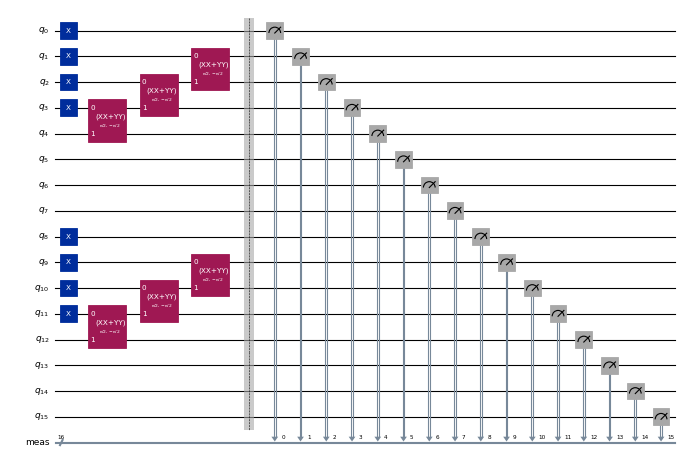

In [4]:
circuits[0].draw("mpl", scale=0.4, fold=-1)

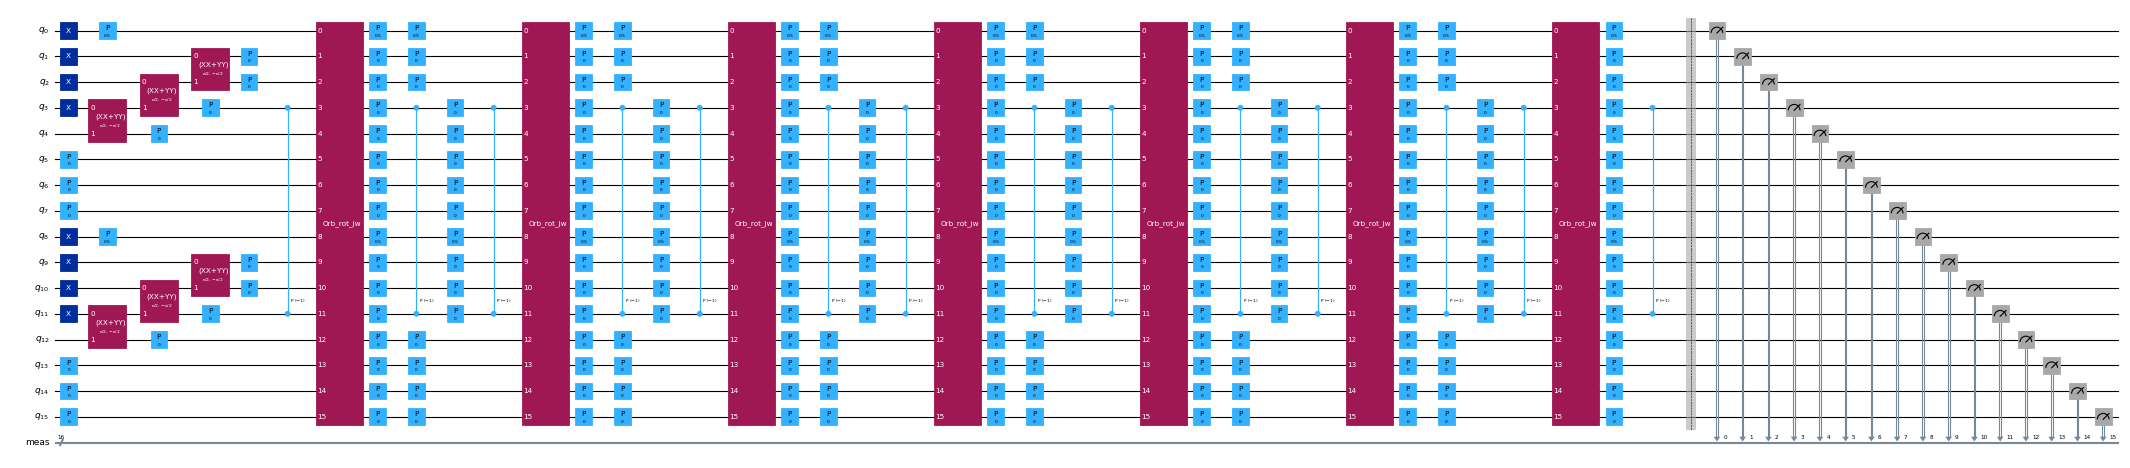

In [5]:
circuits[-1].draw("mpl", scale=0.4, fold=-1)

### Step 2: Optimize the problem

After we have created the Trotterized circuits, we will optimize them for a target hardware. We need to choose the hardware device to use before optimization. We will use a fake 127-qubit backend from ``qiskit_ibm_runtime`` to emulate a real device. To run on a real QPU, just replace the fake backend with a real backend. Check out the [Qiskit IBM Runtime docs](https://docs.quantum.ibm.com/guides/get-started-with-primitives#get-started-with-sampler) for more info.

In [6]:
from qiskit_ibm_runtime.fake_provider.backends import FakeSherbrooke

backend = FakeSherbrooke()

Next, we will transpile the circuits to the target backend using ``qiskit``.

In [7]:
from qiskit.transpiler import generate_preset_pass_manager

# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuits = [pass_manager.run(c) for c in circuits]

### Step 3: Execute experiments

After optimizing the circuits for hardware execution, we are ready to run them on the target hardware and collect samples for ground state energy estimation. Here we use ``SamplerV2`` from ``qiskit-ibm-runtime`` to simulate noisy samples taken from the ``ibm_sherbrooke`` backend. We then combine the counts from each of the Krylov basis states into a single counts dictionary and plot the top 20 most commonly sampled bitstrings. Note the Hartree-Fock bitstring (`0000111100001111`) was the most commonly sampled bitstring.

***Note: [Qiskit Aer](https://qiskit.github.io/qiskit-aer/index.html) is required to simulate samples from transpiled circuits.***

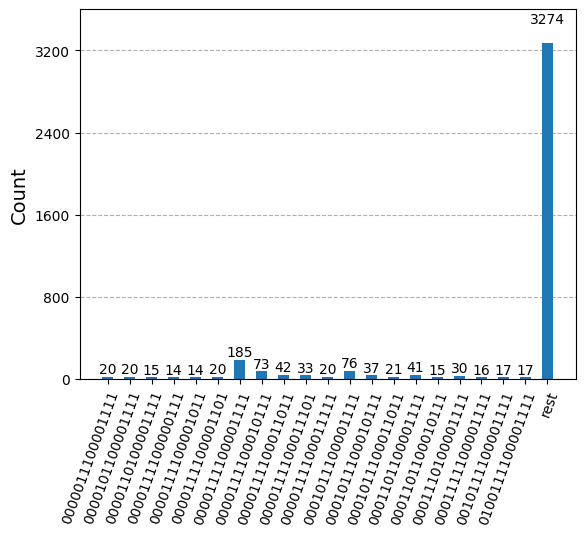

In [8]:
from collections import Counter

from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Sample from the circuits
noisy_sampler = Sampler(backend, options={"simulator": {"seed_simulator": 24}})
job = noisy_sampler.run(isa_circuits, shots=500)

# Combine the counts from the individual Trotter circuits
counts = Counter(job.result()[0].data.meas.get_counts())
for i in range(1, len(job.result())):
    counts += Counter(job.result()[i].data.meas.get_counts())
counts = dict(counts)

plot_histogram(counts, number_to_keep=20)

### Step 4: Post-process the results

First, we will transform the counts into a bitstring matrix and probability array for post-processing.

Each row in the matrix represents one unique bitstring. Since qubits are indexed from the right of a bitstring in Qiskit, column ``0`` represents qubit ``N-1``, and column ``N-1`` represents qubit ``0``, where ``N`` is the number of qubits.

The alpha particles are represented in the column index range ``(N, N/2]``, and the beta particles are represented in the column range ``(N/2, 0]``.

In [9]:
from qiskit_addon_sqd.counts import counts_to_arrays

# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)

Next, we iteratively refine the samples using configuration recovery and approximate the ground state at each iteration

There are a few user-controlled options which are important for this technique:

- ``iterations``: Number of self-consistent configuration recovery iterations
- ``n_batches``: Number of batches of configurations used by the different calls to the eigenstate solver
- ``samples_per_batch``: Number of unique configurations to include in each batch
- ``max_davidson_cycles``: Maximum number of Davidson cycles run by each eigensolver

In [10]:
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import (
    bitstring_matrix_to_ci_strs,
    solve_fermion,
)
from qiskit_addon_sqd.subsampling import postselect_and_subsample

# Set a seed for reproducability
rng = np.random.default_rng(24)

# SQD options
iterations = 9

# Eigenstate solver options
n_batches = 5
samples_per_batch = 450
max_davidson_cycles = 200

# Self-consistent configuration recovery loop
e_hist = np.zeros((iterations, n_batches))  # energy history
s_hist = np.zeros((iterations, n_batches))  # spin history
occupancy_hist = []
avg_occupancy = None
for i in range(iterations):
    print(f"Starting configuration recovery iteration {i}")
    # On the first iteration, we have no orbital occupancy information from the
    # solver, so we begin with the full set of noisy configurations.
    if avg_occupancy is None:
        bs_mat_tmp = bitstring_matrix_full
        probs_arr_tmp = probs_arr_full

    # If we have average orbital occupancy information, we use it to refine the full set of noisy configurations
    else:
        bs_mat_tmp, probs_arr_tmp = recover_configurations(
            bitstring_matrix_full,
            probs_arr_full,
            avg_occupancy,
            nelec[0],
            nelec[1],
            rand_seed=rng,
        )

    # Create batches of subsamples. We post-select here to remove configurations
    # with incorrect hamming weight during iteration 0, since no config recovery was performed.
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=nelec[0],
        hamming_left=nelec[1],
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rng,
    )

    # Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
    e_tmp = np.zeros(n_batches)
    s_tmp = np.zeros(n_batches)
    occs_tmp = []
    coeffs = []
    for j in range(n_batches):
        strs_a, strs_b = bitstring_matrix_to_ci_strs(batches[j])
        print(f"Batch {j} subspace dimension: {len(strs_a) * len(strs_b)}")
        energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
            batches[j],
            h1e,
            h2e,
            max_davidson=max_davidson_cycles,
        )
        e_tmp[j] = energy_sci
        s_tmp[j] = spin
        occs_tmp.append(avg_occs)
        coeffs.append(coeffs_sci)

    # Combine batch results
    avg_occupancy = np.mean(occs_tmp, axis=0)

    # Track optimization history
    e_hist[i, :] = e_tmp
    s_hist[i, :] = s_tmp
    occupancy_hist.append(avg_occupancy)

Starting configuration recovery iteration 0
Batch 0 subspace dimension: 3721
Batch 1 subspace dimension: 3721
Batch 2 subspace dimension: 3721
Batch 3 subspace dimension: 3721
Batch 4 subspace dimension: 3721
Starting configuration recovery iteration 1
Batch 0 subspace dimension: 4356
Batch 1 subspace dimension: 4489
Batch 2 subspace dimension: 4624
Batch 3 subspace dimension: 4356
Batch 4 subspace dimension: 4096
Starting configuration recovery iteration 2
Batch 0 subspace dimension: 4489
Batch 1 subspace dimension: 4624
Batch 2 subspace dimension: 4489
Batch 3 subspace dimension: 4356
Batch 4 subspace dimension: 4624
Starting configuration recovery iteration 3
Batch 0 subspace dimension: 4624
Batch 1 subspace dimension: 4489
Batch 2 subspace dimension: 4356
Batch 3 subspace dimension: 4489
Batch 4 subspace dimension: 4761
Starting configuration recovery iteration 4
Batch 0 subspace dimension: 4624
Batch 1 subspace dimension: 4761
Batch 2 subspace dimension: 4761
Batch 3 subspace dime

The first plot shows that after a couple of iterations we estimate the ground state energy within ``~1.9 mH`` (chemical accuracy is typically accepted to be ``1 kcal/mol`` $\approx$ ``1.6 mH``).

The second plot shows the average occupancy of each spatial orbital after the final iteration. We see that with high probability, each orbital contains one electron in our solutions.

Exact energy: -13.42249 Ha
SQD energy: -13.42237 Ha
Absolute error: 0.00012 Ha


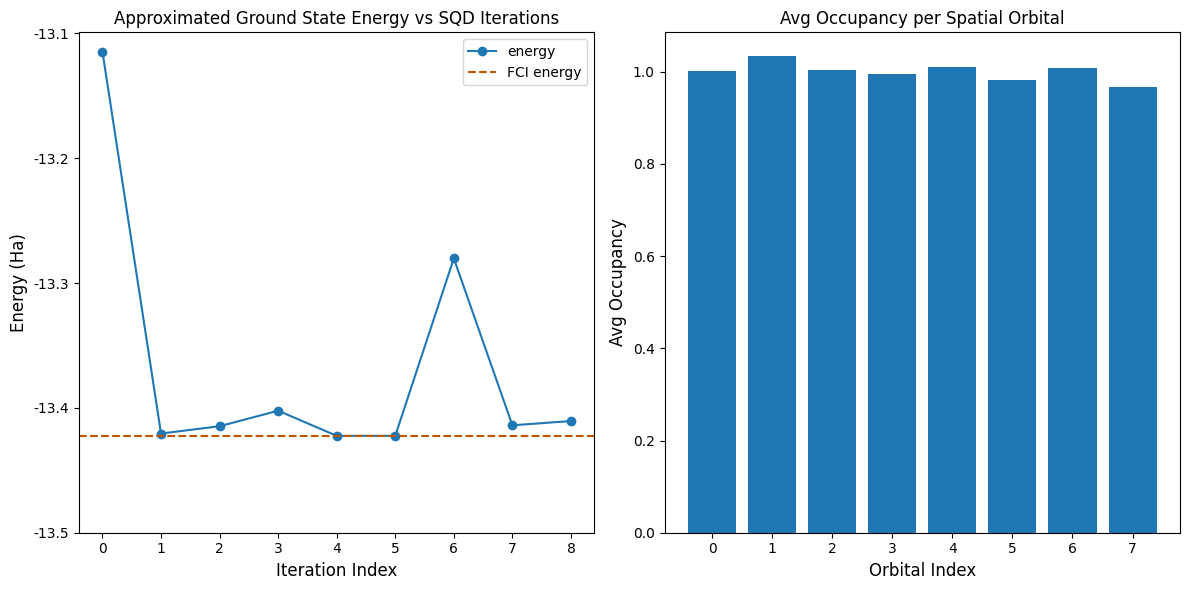

In [11]:
import matplotlib.pyplot as plt

exact_energy = -13.422491814605827
min_es = [np.min(e) for e in e_hist]
min_id, min_e = min(enumerate(min_es), key=lambda x: x[1])

# Data for energies plot
x1 = range(iterations)
yt1 = list(np.arange(-13.5, -13.1, 0.1))
ytl = [f"{i:.1f}" for i in yt1]

# Data for avg spatial orbital occupancy
avg_occupancy = occupancy_hist[min_id]
y2 = avg_occupancy[0] + avg_occupancy[1]
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, min_es, label="energy", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(ytl)
axs[0].axhline(y=exact_energy, color="#BF5700", linestyle="--", label="FCI energy")
axs[0].set_title("Approximated Ground State Energy vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f} Ha")
print(f"SQD energy: {min_e:.5f} Ha")
print(f"Absolute error: {abs(min_e - exact_energy):.5f} Ha")
plt.tight_layout()
plt.show()